# Example: Running MultiSolSegment on test images and calculating pvimage statistics

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

from pvcracks.utils import train_functions

import requests

from pvimage import features
from PIL import Image
import torchvision.transforms.functional as F
from torchvision import transforms
from pvcracks.utils.segmentation import segment
from sklearn.preprocessing import MinMaxScaler

## Download Model

In [ ]:
weight_path = "multisolsegment.pt"
response = requests.get(
    "https://datahub.duramat.org/dataset/24d7ed98-956e-4ebc-bf21-6584ecec2ff1/resource/e6d5dee2-0aef-439e-978c-d8c572e7039e/download/model.pt"
)

with open(weight_path, "wb") as f:
    f.write(response.content)

## Set Local Paths

In [ ]:
files_root = (
    "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/MultiSolSegment_New_Test_Images/"
)

In [4]:
# Browse all folders and subfolders in files_root directory and get all file names

img_paths = list(Path(files_root).rglob("*.png"))
img_paths += list(Path(files_root).rglob("*.jpg"))
img_paths += list(Path(files_root).rglob("*.jpeg"))
img_paths += list(Path(files_root).rglob("*.tiff"))
img_paths += list(Path(files_root).rglob("*.tif"))

print(f"Found {len(img_paths)} images in {files_root}")

Found 608 images in /Users/ojas/Desktop/saj/SANDIA/pvcracks_data/MultiSolSegment_New_Test_Images/


## Load in

In [5]:
category_mapping = {0: "dark", 1: "busbar", 2: "crack", 3: "non-cell"}

device, model = train_functions.load_device_and_model(
    category_mapping, existing_weight_path=weight_path
)

## Process all images

In [6]:
masks = []

for i, img_path in enumerate(img_paths):
    image_raw = Image.open(img_path)
    image_rgb = image_raw.convert("RGB")
    image_rot = image_rgb.rotate(90)
    image = F.resize(
        image_rot, (400, 400), interpolation=transforms.InterpolationMode.BILINEAR
    )

    dark, bb, crack, nocell = segment(image, device, model)
    crack_mask = (crack * 255).astype(np.uint8)

    masks.append(crack_mask)

    print(f"Processed image {i + 1}/{len(img_paths)}: {img_path.name}")

Processed image 1/608: M4B_17s1_10_s_cr.png
Processed image 2/608: M4B_17s0_15_s_cr.png
Processed image 3/608: M4B_17s2_10_s_cr.png
Processed image 4/608: M4B_17s3_10_s_cr.png
Processed image 5/608: 209_C1_0005_2021_04_26_17_20_38_Deg1_30s_100_500_500.png
Processed image 6/608: 209_C1_0005_2021_04_22_15_49_43_Init_30s_100_500_500.png
Processed image 7/608: 209_C1_0005_2021_04_28_11_29_22_Deg2_30s_100_500_500.png
Processed image 8/608: M4B_10s1_10_s_cr.png
Processed image 9/608: M4B_10s0_15_s_cr.png
Processed image 10/608: M4B_10s2_10_s_cr.png
Processed image 11/608: M4B_10s3_10_s_cr.png
Processed image 12/608: M0B_Sun02_s1_100%_021_100_1_s_cr.png
Processed image 13/608: M0B_Sun02_s0_100%_084_100_1_s_cr.png
Processed image 14/608: M0B_Sun02_s2_100%_116_100_5_s_cr.png
Processed image 15/608: M0B_Sun02_s3_100%_134_100_5_s_cr.png
Processed image 16/608: M4B_19s1_10_s_cr.png
Processed image 17/608: M4B_19s0_5_s_cr.png
Processed image 18/608: M4B_19s2_10_s_cr.png
Processed image 19/608: M4B_

## Run PVImage feature extraction across all predicted crack masks

In [7]:
info_df = pd.DataFrame({"impath": img_paths})

features_df = features.feature_extraction_crack_mask(masks, info_df)
display(features_df.head())

/Users/ojas/Desktop/saj/SANDIA/pvcracks/.venv/lib/python3.11/site-packages/pvimage/features.py:59: RuntimeWarning: invalid value encountered in divide
  mask2n = mask2/mask2.max()


,cell_number,i,prop.perimeter,slope,prop.convex_area,prop.area,prop.orientation
0,M4B_17s1_10_s_cr,0,3633.125251,-0.034274,52564.0,33044.0,-0.097034
0,M4B_17s1_10_s_cr,3,113.740115,-1.07365,676.0,630.0,-0.976621
0,M4B_17s2_10_s_cr,0,5656.68683,-0.084092,92762.0,46628.0,-1.108149
0,M4B_17s2_10_s_cr,1,360.622366,-0.929278,3494.0,2338.0,-1.149325
0,M4B_17s3_10_s_cr,0,6195.687876,-0.227762,105957.0,49583.0,-0.922617


In [8]:
features_df["count_features"] = features_df.groupby("cell_number")[
    "cell_number"
].transform("count")
features_count_df = features_df.sort_values(by="cell_number").drop_duplicates(
    "cell_number", keep="first"
)
features_count_df.reset_index(drop=True, inplace=True)

featurescounted_multi = pd.concat(
    [features_count_df["count_features"]], axis=1, ignore_index=True
)
featurescounted_multi.columns = ["Original"]

# Show basic outputs
print(f"Processed {len(masks)} images, extracted {len(features_df)} feature rows.")
display(featurescounted_multi.head())

Processed 608 images, extracted 1902 feature rows.


,Original
0,2
1,7
2,7
3,5
4,5


## Plot results

In [9]:
def violinplt(data, palette=None, figsize=(5, 4)):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Coerce to DataFrame so .mean() and column names behave
    if isinstance(data, pd.Series):
        data = data.to_frame()
    elif not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)

    fig, ax = plt.subplots(figsize=figsize)

    # Seaborn API: no widths/showmeans/showmedians/showextrema here
    # Use inner="quartile" to show quartiles; cut=0 to avoid extrapolation
    sns.violinplot(
        data=data,
        ax=ax,
        palette=palette,
        inner="quartile",
        cut=0,
        linewidth=1,
    )

    # Overlay means as points
    means = data.mean().to_numpy()
    x_pos = np.arange(len(means))
    ax.scatter(x_pos, means, zorder=3)

    # Prepare mean labels
    nobs = [f"{m:.2f}" for m in means]

    # Place mean labels slightly above the point
    y_offset = 0.03 * (
        np.nanmax(means) - np.nanmin(means) if np.all(np.isfinite(means)) else 1.0
    )
    if len(x_pos) > 3:
        for i in x_pos:
            t = ax.text(
                i,
                means[i] + y_offset,
                nobs[i],
                ha="center",
                va="bottom",
                fontsize=10,
                color="black",
                weight="semibold",
            )
            # subtle white box for readability
            t.set_bbox(
                dict(
                    facecolor="white",
                    alpha=0.5,
                    edgecolor="none",
                    boxstyle="round,pad=0.15",
                )
            )
        # Rotate tick labels cleanly
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    else:
        for i in x_pos:
            ax.text(
                i,
                means[i] + y_offset,
                nobs[i],
                ha="center",
                va="bottom",
                fontsize=12,
                color="black",
                weight="semibold",
            )

    ax.set_ylabel("Value")
    ax.set_xlabel("")
    ax.margins(x=0.05)
    fig.tight_layout()
    return fig

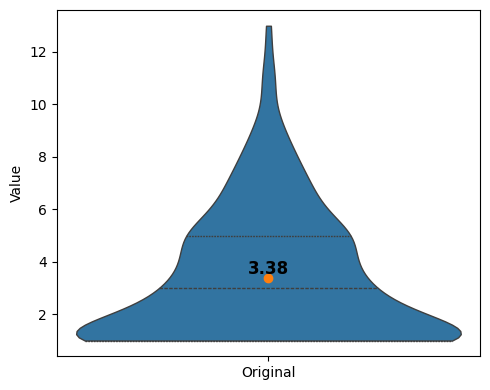

In [10]:
vp = violinplt(featurescounted_multi[["Original"]], figsize=(5, 4))

/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_82581/2243438065.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dffeatures_multi_norm[columnstonormalize] = scaler.fit_transform(dffeatures_multi_norm)


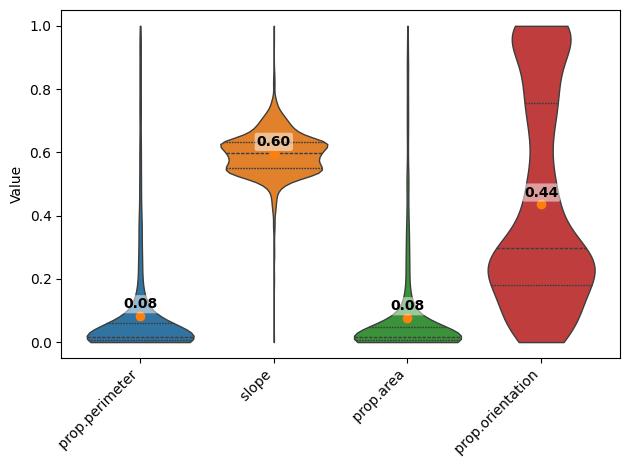

In [11]:
scaler = MinMaxScaler()
columnstonormalize = [
    " prop.perimeter",
    " slope",
    " prop.area",
    " prop.orientation",
]
dffeatures_multi_norm = features_df[columnstonormalize]
dffeatures_multi_norm[columnstonormalize] = scaler.fit_transform(dffeatures_multi_norm)
fig = violinplt(
    dffeatures_multi_norm[
        [
            " prop.perimeter",
            " slope",
            " prop.area",
            " prop.orientation",
        ]
    ],
    figsize=None,
)